# Computing main simulation results

In [124]:
%load_ext autoreload
%autoreload 2
import os
import sys

import time 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import date
from copy import deepcopy

from predCoding import *

# for updating after changes in imported files
from utils import *
from plot_utils import *

plt.rcParams['figure.figsize'] = [full_width,2/3* full_width]
plt.rcParams['figure.dpi'] = 100


In [48]:
default_params = {'nNeur' :   100, 
                  'ratePosWeights' : 0.5,
                  'lambd' :    0.05, # time constant 1/lambda should be around 20ms
                  'sigma_V' :  1,
                  'linCost' :  1,
                  'quadCost' : 1,
                  'connStrength' : 5,
                 'tau': 5}

default_input = input_cst

default_spikeMod = {**default_params,
                    'input_fct': default_input, 
                    'T': 200, 
                    't_step': 0.01}

# to modify parameters easily 

def setPar(d=None,**kwargs):
    if d  is None:                                
        d=dict(**default_spikeMod)
    for key, arg in kwargs.items():
        d[key]=arg
    return d

In [79]:
spikeM=spikeMod_sim(**setPar())

#### Firing rates vs. $\tau_h$

__Note__: Synchronisation can arise due to numerical issues. To avoid this problem, simulations where synchronisation occurs are discarded from the computations. A corresponding warning (sims=simulations) is given in these cases.

In [44]:
fr_plus_lif,fr_minus_lif=avs_over_sims_lif(mean_fir_rates,100,target_dims=2,
               **setPar(sigma_V=0.5,T=500))[0]
fr_plus_lif_1k,fr_minus_lif_1k=avs_over_sims_lif(mean_fir_rates,30,target_dims=2,
               **setPar(sigma_V=0.5,T=500,nNeur=1000))[0]

In [54]:
%%time
tau_vals1=[1,2.5,5,7.5,10,12.5,15,17.5,20]
baseM_match= rateMod_sim_fast(**setPar(sigma_V=0.5,T=500))
%time fr_plus_r,fr_minus_r=fr_over_tau(tau_vals1,nSims=70,base_model=baseM_match)

6it [16:39, 167.83s/it]WARNING:root:High standard error: SEM is 4% of the mean for tau: 15
8it [22:13, 167.25s/it]WARNING:root:High standard error: SEM is 5% of the mean for tau: 20
9it [25:01, 166.79s/it]

CPU times: user 24min 54s, sys: 2.18 s, total: 24min 56s
Wall time: 25min 1s
CPU times: user 24min 57s, sys: 2.22 s, total: 24min 59s
Wall time: 25min 3s


In [52]:
%%time
baseM_match_1k= rateMod_sim_fast(**setPar(sigma_V=0.5,nNeur=1000,T=500))
fr_plus_r_1k,fr_minus_r_1k=fr_over_tau(tau_vals1,base_model=baseM_match_1k)

9it [05:52, 39.16s/it]

CPU times: user 5min 57s, sys: 765 ms, total: 5min 58s
Wall time: 5min 58s


In [35]:
dict_res0={'fr_plus_lif':fr_plus_lif,'fr_minus_lif':fr_minus_lif,
           'fr_plus_lif_1k':fr_plus_lif_1k,'fr_minus_lif_1k':fr_minus_lif_1k,
           'fr_plus_r_1k':fr_plus_r_1k,
 'fr_plus_r':fr_plus_r,
          'fr_minus_r':fr_minus_r,
 'fr_minus_r_1k':fr_minus_r_1k}

Uncomment the following to save results via pickle

In [36]:
#with open('res_tau_1409', 'wb') as fp:
#    pickle.dump(dict_res0, fp)

Text(0.5, 0, '$\\tau_h$ (ms)')

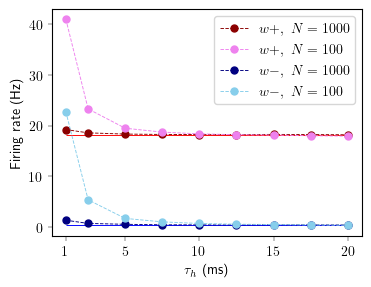

In [61]:
plt.figure(figsize=[4,3])
plt.hlines(fr_plus_lif_1k,tau_vals1[0],tau_vals1[-1],'r','-')
plt.plot(tau_vals1,fr_plus_r_1k,'--o',c='darkred',markersize=5,label=r'$w+,\ N=1000$')
plt.plot(tau_vals1,fr_plus_r,'--o',c='violet',markersize=5,    label=r'$w+,\ N=100$')
plt.hlines(fr_minus_lif_1k,tau_vals1[0],tau_vals1[-1],'b','-')
plt.plot(tau_vals1,fr_minus_r_1k,'--o',c='navy',markersize=5,  label=r'$w-,\ N=1000$')
plt.plot(tau_vals1,fr_minus_r,'--o',c='skyblue',markersize=5,  label=r'$w-,\ N=100$')
plt.xticks(tau_vals1[::2])
plt.legend()
plt.ylabel('Firing rate (Hz)')
plt.xlabel(r'$\tau_h$ (ms)') 

### Comparison of LIF and Poisson models for stationary inputs

Note: The CV requires very long simulation times, while the other statistics can be estimated more efficiently by using more simulations over shorter simulation time.

In [63]:
funcs_list=[mean_fir_rates,cv,mean_est_sim,var_readout_sim]
func_dims_list=[2,1,1,1]
x_grid=np.arange(0,6,1)
tau_vals=[1,5,10]

In [66]:
sim1_pars_spec={'sigma_V':0.5, "T":1000}
sim1_pars=setPar(sigma_V=0.5,T=1000)
baseM_sim1=rateMod_sim_fast(sparse=True,manualSim=True,**sim1_pars)

In [90]:
%%time
lif_sim1=av_fcts_over_1Dgrid_lif(funcs_list,'x',x_grid,nSims=100,
                     target_dims=func_dims_list, **sim1_pars)

0it [00:00, ?it/s]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=0)
1it [05:54, 354.31s/it]WARNING:root:Skipped 3 sims due to synchronisation for x=1
2it [11:29, 342.83s/it]WARNING:root:High standard error: SEM is 10% of the mean for x=2 (mean_fir_rates)
3it [16:44, 330.51s/it]WARNING:root:High standard error: SEM is 37% of the mean for x=3 (mean_fir_rates)
6it [32:33, 325.66s/it]

CPU times: user 32min 20s, sys: 2.76 s, total: 32min 22s
Wall time: 32min 33s


In [93]:
%%time
res_sim1=av_fct_over_2Dgrid_p(funcs_list,'x',x_grid,'tau',tau_vals,nSims=50,
                     target_dims=func_dims_list,
                     base_model=baseM_sim1)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 171% of the mean for x: 0, tau: 1 (mean_est_sim)
2it [23:57, 718.51s/it]WARNING:root:High standard error: SEM is 5% of the mean for x: 2, tau: 10 (mean_fir_rates)
3it [35:54, 717.76s/it]WARNING:root:High standard error: SEM is 9% of the mean for x: 3, tau: 10 (mean_fir_rates)
4it [47:50, 717.19s/it]WARNING:root:High standard error: SEM is 6% of the mean for x: 4, tau: 5 (mean_fir_rates)
5it [59:49, 717.99s/it]WARNING:root:High standard error: SEM is 7% of the mean for x: 5, tau: 5 (mean_fir_rates)
6it [1:11:44, 717.41s/it]

CPU times: user 1h 11min 27s, sys: 5.8 s, total: 1h 11min 33s
Wall time: 1h 11min 44s


__N=1000__

In [95]:
sim1_pars_1k=setPar(sigma_V=0.5,T=1000,nNeur=1000)
baseM_sim1_1k=rateMod_sim_fast(sparse=True,manualSim=True,**sim1_pars_1k)

In [97]:
%%time
lif_sim1_1k=av_fcts_over_1Dgrid_lif(funcs_list,'x',x_grid,nSims=50,
                     target_dims=func_dims_list,**sim1_pars_1k)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 65% of the mean for x=0 (mean_est_sim)
2it [12:47, 383.63s/it]WARNING:root:High standard error: SEM is 5% of the mean for x=2 (mean_fir_rates)
3it [19:10, 383.44s/it]WARNING:root:High standard error: SEM is 48% of the mean for x=3 (mean_fir_rates)
6it [38:23, 383.95s/it]

CPU times: user 38min 13s, sys: 4.02 s, total: 38min 17s
Wall time: 38min 23s


In [103]:
%%time
res_sim1_1k=av_fct_over_2Dgrid_p(funcs_list,'x',x_grid,'tau',tau_vals,nSims=100,
                     target_dims=func_dims_list,
                     base_model=baseM_sim1_1k)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 67% of the mean for x: 0, tau: 1 (mean_est_sim)
3it [2:00:36, 2402.89s/it]WARNING:root:High standard error: SEM is 8% of the mean for x: 3, tau: 5 (mean_fir_rates)
4it [2:40:34, 2401.12s/it]WARNING:root:High standard error: SEM is 31% of the mean for x: 4, tau: 5 (mean_fir_rates)
5it [19:47:53, 23762.53s/it]WARNING:root:High standard error: SEM is 4% of the mean for x: 5, tau: 1 (mean_fir_rates)
6it [20:28:30, 12285.12s/it]

CPU times: user 3h 59min 48s, sys: 34.6 s, total: 4h 23s
Wall time: 20h 28min 30s


In [106]:
fr_sim1,cv_sim1,mean_sim1,var_sim1=res_sim1
fr_sim1_1k,cv_sim1_1k,mean_sim1_1k,var_sim1_1k=res_sim1_1k
fr_sim1_lif,cv_sim1_lif,mean_sim1_lif,var_sim1_lif=lif_sim1
fr_sim1_lif_1k,cv_sim1_lif_1k,mean_sim1_lif_1k,var_sim1_lif_1k=lif_sim1_1k

In [30]:
cols_p=plt.get_cmap('hot')

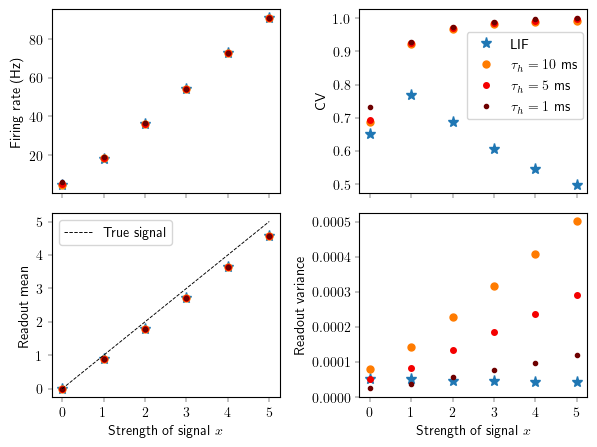

In [107]:
plt.rcParams.update({'text.usetex':True})
fig, axs =plt.subplots(2,2,sharex=True,figsize=[full_width,3*full_width/4])

plot_list_lif=[fr_sim1_lif_1k[:,0], cv_sim1_lif_1k, mean_sim1_lif_1k, var_sim1_lif_1k]
plot_list_p=[fr_sim1_1k[:,:,0], cv_sim1_1k, mean_sim1_1k, var_sim1_1k]
y_labels=['Firing rate (Hz)', 'CV', 'Readout mean', 'Readout variance']
for i, ax in enumerate(axs.reshape(-1)):
    lif_line,=ax.plot(x_grid,plot_list_lif[i],'*',c=col_lif,markersize=8,label='LIF')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_p[i][:,j], 'o',markersize=3+j,c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
    ax.set_ylabel(y_labels[i])

for lower_ax in axs[1,:]:
    lower_ax.set_xlabel(r'Strength of signal  $x$')
    lower_ax.set_xticks(x_grid)
axs[1,1].set_ylim(0)    
l_mean,=axs[1,0].plot(x_grid,'k--',label='True signal')
axs[1,0].legend([l_mean],['True signal'])
handles, labels = axs[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0,1].legend(by_label.values(), by_label.keys(),bbox_to_anchor=[0.44,0.64])
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'match_pois_vs_lif'),bbox_inches='tight',dpi=300)   

### Recompute CV

Simulation over a longer time span is required to obtain a meaningful approximation for the coefficient of variation.

In [125]:
cv_sim1_lif=av_fcts_over_1Dgrid_lif(cv,'x',x_grid,nSims=5,
                     target_dims=1,sigma_V=0.5,T=10000,nNeur=100)
cv_sim1_lif_1k=av_fcts_over_1Dgrid_lif(cv,'x',x_grid,nSims=5,
                     target_dims=1,sigma_V=0.5,T=10000,nNeur=1000)

0it [00:00, ?it/s]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=0)
1it [08:25, 505.60s/it]WARNING:root:Skipped 1 sims due to synchronisation for x=1
6it [22:05, 220.93s/it]
6it [38:38, 386.45s/it]


In [132]:
cv_sim1=av_fct_over_2Dgrid_p(cv,'x',x_grid,'tau',tau_vals,nSims=5,
                     target_dims=1, base_model=baseM_sim1,T=10000)
cv_sim1_1k=av_fct_over_2Dgrid_p(cv,'x',x_grid,'tau',tau_vals,nSims=5,
                     target_dims=1, base_model=baseM_sim1_1k,T=10000)

6it [1:12:06, 721.07s/it]
6it [28:58:54, 17389.02s/it]


Now the results look better:

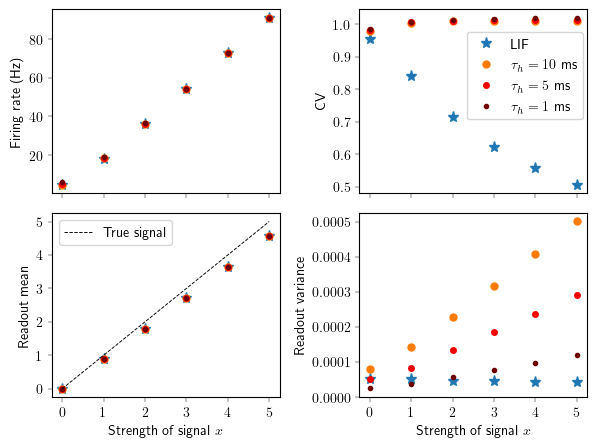

In [137]:
plt.rcParams.update({'text.usetex':True})
fig, axs =plt.subplots(2,2,sharex=True,figsize=[full_width,3*full_width/4])

plot_list_lif=[fr_sim1_lif_1k[:,0], cv_sim1_lif_1k, mean_sim1_lif_1k, var_sim1_lif_1k]
plot_list_p=[fr_sim1_1k[:,:,0], cv_sim1_1k, mean_sim1_1k, var_sim1_1k]
y_labels=['Firing rate (Hz)', 'CV', 'Readout mean', 'Readout variance']
for i, ax in enumerate(axs.reshape(-1)):
    lif_line,=ax.plot(x_grid,plot_list_lif[i],'*',c=col_lif,markersize=8,label='LIF')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_p[i][:,j], 'o',markersize=3+j,c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
    ax.set_ylabel(y_labels[i])

for lower_ax in axs[1,:]:
    lower_ax.set_xlabel(r'Strength of signal  $x$')
    lower_ax.set_xticks(x_grid)
axs[1,1].set_ylim(0)    
l_mean,=axs[1,0].plot(x_grid,'k--',label='True signal')
axs[1,0].legend([l_mean],['True signal'])
handles, labels = axs[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0,1].legend(by_label.values(), by_label.keys(),bbox_to_anchor=[0.44,0.64])
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'match_pois_vs_lif'),bbox_inches='tight',dpi=300)   

##### $\sigma_V=1$

In [108]:
sim2_pars=setPar(sigma_V=1,T=5000)
baseM_sim2=rateMod_sim_fast(sparse=True,manualSim=True,**sim2_pars)

sim2_pars_1k=setPar(sigma_V=1,T=5000,nNeur=1000)
baseM_sim2_1k=rateMod_sim_fast(sparse=True,manualSim=True,**sim2_pars_1k)

In [109]:
%%time
lif_sim2=av_fcts_over_1Dgrid_lif(funcs_list,'x',x_grid,nSims=15,
                     target_dims=func_dims_list,**sim2_pars)

0it [00:00, ?it/s]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=0)
1it [06:56, 416.08s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=1)
2it [13:47, 413.49s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=2)
3it [20:41, 413.82s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=3)
4it [27:37, 414.47s/it]WARNING:root:Skipped 3 sims due to synchronisation for x=4
6it [36:29, 364.97s/it]

CPU times: user 36min 17s, sys: 4.71 s, total: 36min 22s
Wall time: 36min 29s


In [111]:
%%time
lif_sim2_1k=av_fcts_over_1Dgrid_lif(funcs_list,'x',x_grid,nSims=5,
                     target_dims=func_dims_list,**sim2_pars_1k)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 91% of the mean for x=0 (mean_est_sim)
6it [19:39, 196.65s/it]

CPU times: user 19min 9s, sys: 20.6 s, total: 19min 29s
Wall time: 19min 39s


In [112]:
%%time
res_sim2=av_fct_over_2Dgrid_p(funcs_list,'x',x_grid,'tau',tau_vals,nSims=5,
                     target_dims=func_dims_list,
                     base_model=baseM_sim2)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 81% of the mean for x: 0, tau: 1 (mean_est_sim)
5it [30:03, 360.59s/it]WARNING:root:High standard error: SEM is 4% of the mean for x: 5, tau: 10 (mean_fir_rates)
6it [36:04, 360.78s/it]

CPU times: user 35min 52s, sys: 6.16 s, total: 35min 59s
Wall time: 36min 4s


In [113]:
%%time
res_sim2_1k=av_fct_over_2Dgrid_p(funcs_list,'x',x_grid,'tau',tau_vals,nSims=5,
                     target_dims=func_dims_list,
                     base_model=baseM_sim2_1k)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 92% of the mean for x: 0, tau: 1 (mean_est_sim)
6it [1:01:07, 611.18s/it]

CPU times: user 59min 46s, sys: 58.5 s, total: 1h 45s
Wall time: 1h 1min 7s


In [116]:
fr_sim2,       cv_sim2,       mean_sim2,       var_sim2        = res_sim2
fr_sim2_1k,    cv_sim2_1k,    mean_sim2_1k,    var_sim2_1k     = res_sim2_1k
fr_sim2_lif,   cv_sim2_lif,   mean_sim2_lif,   var_sim2_lif    = lif_sim2
fr_sim2_lif_1k,cv_sim2_lif_1k,mean_sim2_lif_1k,var_sim2_lif_1k = lif_sim2_1k

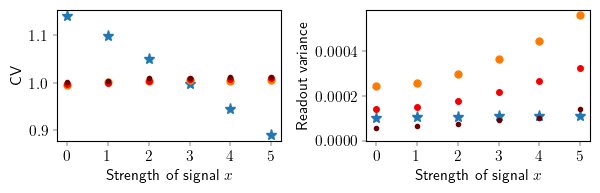

In [56]:
fig, axs =plt.subplots(1,2,figsize=[full_width,full_width/3])

plot_list_lif=[cv_sim2_lif_1k, var_sim2_lif_1k]
plot_list_p=[cv_sim2_1k, var_sim2_1k]
y_labels=['CV', 'Readout variance']
for i, ax in enumerate(axs):
    lif_line,=ax.plot(x_grid,plot_list_lif[i],'*',c=col_lif,markersize=8,label='LIF model')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_p[i][:,j], 'o',markersize=3+j,c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
    ax.set_ylabel(y_labels[i])
    ax.set_xlabel(r'Strength of signal  $x$')
    ax.set_xticks(x_grid)
axs[1].set_ylim(0)
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'pois_vs_lif_sig1'),bbox_inches='tight',dpi=300)   

### Dumping results

In [601]:
dict_res1={'lif_sim1':lif_sim1,'lif_sim1_1k':lif_sim1_1k,
          'lif_sim2':lif_sim2, 'lif_sim2_1k':lif_sim2_1k,
    'res_sim1':res_sim1,'res_sim1_1k':res_sim1_1k,'res_sim2':res_sim2,
 'res_sim2_1k':res_sim2_1k}

In [602]:
#with open('data/res_temp_0210', 'wb') as fp:
#    pickle.dump(dict_res1, fp)

# Mean-field results

In [118]:
N_vals=np.append(100,np.arange(500,5001,500))
simN_pars_spec={'sigma_V':0.5,'T':1000}
simN_pars=setPar(**simN_pars_spec)

In [119]:
spikeM=spikeMod_sim(**setPar(input_fct=lambda t: input_cst(t,1),connStrength=3,sigma_V=0.5))
def plt2mean_rels(pc_sim,ax=None):
    if ax==None: ax=plt.gca()
    mean_q_grid = np.arange(-0.1,0.1,0.001)
    first_rel_mean_x= first_mean_rel(pc_sim, mean_q_grid)
    second_rel_mean_x = second_mean_rel(pc_sim, mean_q_grid)
    ax.plot(mean_q_grid,first_rel_mean_x, 'C1',label='First relation')
    ax.plot(mean_q_grid,second_rel_mean_x,'C2', label='Second relation')
    ax.hlines(meanw_est_sim(pc_sim),mean_q_grid[0],mean_q_grid[-1],linestyles='--', label='LIF simulation')
    ax.set_ylabel(r'$\langle \hat x \rangle$')
    ax.set_xlabel(r'$\langle q \rangle$')
#plt2mean_rels(spikeM)

In [120]:
def plt_mf_means(x_grid,mean_sims,means_anal,ax=None):
    if ax==None: ax=plt.gca()
    ax.plot(x_grid,x_grid,'k--', label='True signal x')
    ax.plot(x_grid,means_anal, 'orange', label='Analytical prediction')
    ax.plot(x_grid,mean_sims,'b*',markersize=5, label='Simulation results')
    ax.set_ylabel(r'$\langle \hat x \rangle$')
    ax.set_xlabel(r'$x$')
#plt_mf_means(x_grid,mean_sim1_lif_1k,res_means_anal)

In [121]:
res_means_anal=np.zeros(x_grid.size)
for i,s in enumerate(x_grid/20):
    res_means_anal[i]=calc_mf_means(baseM_sim1_1k,s)[0]

In [122]:
%%time
lif_simN=av_fcts_over_1Dgrid_lif(funcs_list,'nNeur',N_vals,nSims=20,
                     target_dims=func_dims_list,**simN_pars)

0it [00:00, ?it/s]WARNING:root:High standard error: SEM is 5% of the mean for nNeur=100 (mean_fir_rates)
11it [4:56:01, 1614.68s/it]

CPU times: user 1h 29min 32s, sys: 3min 1s, total: 1h 32min 33s
Wall time: 4h 56min 1s


In [123]:
p_simN=av_fct_over_2Dgrid_p(funcs_list,'nNeur',N_vals,'tau',tau_vals,nSims=20,
                     target_dims=func_dims_list,**simN_pars)

11it [2:35:04, 845.82s/it] 


In [128]:
%%time
N_grid=np.arange(100,5000)
meansN_anal=np.zeros(N_grid.size)
for i,N in enumerate(N_grid):
    sim_i=gen_model(**setPar(nNeur=N,**simN_pars_spec))
    meansN_anal[i]=calc_mf_means(sim_i)[0]    

CPU times: user 13.1 s, sys: 217 ms, total: 13.3 s
Wall time: 13.5 s


In [129]:
fr_simN_lif,   cv_simN_lif,   mean_simN_lif,   var_simN_lif    = lif_simN
fr_simN_p,   cv_simN_p,   mean_simN_p,   var_simN_p    = p_simN

In [89]:
def pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN,ax=None):
    if ax==None: ax=plt.gca()
    ax.plot(N_grid,meansN_anal,'orange',label='Theory')
    ax.plot(N_vals,mean_simN_p[:,1],'C1o',markersize=3,label='Poisson simulation')
    ax.plot(N_vals,mean_simN_lif,'b*',markersize=5, label='LIF simulation')
    ax.set_xticks(N_vals[::2])
    ax.set_xlabel('Network size N')
    ax.set_ylabel(r'$\langle \hat x \rangle$')
#pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN_lif)

In [63]:
sim_i=gen_model(**setPar(nNeur=100,**simN_pars_spec))
calc_mf_means(sim_i)[0]   

array([0.86026395])

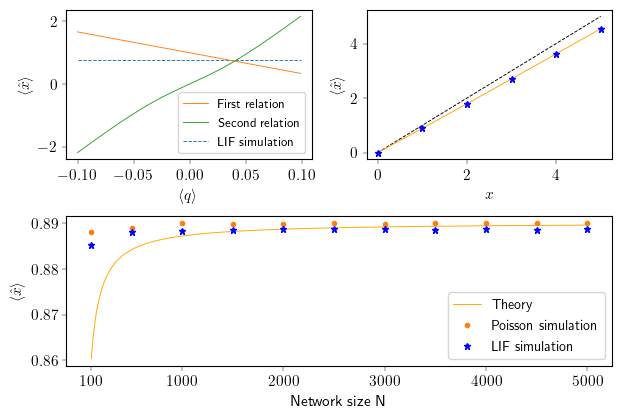

In [90]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax=fig.add_subplot(gs[0,0])
plt2mean_rels(spikeM)
ax.legend(fontsize=9)
ax=fig.add_subplot(gs[0,1])
plt_mf_means(x_grid,mean_sim1_lif_1k,res_means_anal)
ax = fig.add_subplot(gs[1,:])
pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN_lif,ax)
ax.legend()
#plt.savefig(os.path.join(SAVEFIG_PATH,'means_mf'),bbox_inches='tight',dpi=300)   

In [484]:
dict_res2={'lif_simN':lif_simN,'p_simN':p_simN}

In [485]:
#with open('data/res_mf_means_2509', 'wb') as fp:
#    pickle.dump(dict_res2, fp)

## MF variance

### recompute variance with more precision

In [6]:
sim3_pars=setPar(sigma_V=1.5,T=1000)
baseM_sim3=rateMod_sim_fast(sparse=True,manualSim=True,**sim3_pars)

sim3_pars_1k=setPar(sigma_V=1.5,T=1000,nNeur=1000)
baseM_sim3_1k=rateMod_sim_fast(sparse=True,manualSim=True,**sim3_pars_1k)

In [139]:
lif_var3=av_fcts_over_1Dgrid_lif(var_readout_sim,'x',x_grid,nSims=50,
                     sigma_V=1.5,T=1000)

0it [00:00, ?it/s]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=0)
1it [03:11, 191.95s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=1)
2it [06:24, 192.02s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=2)
3it [09:36, 192.40s/it]WARNING:root:Skipped over 10 sims due to synchronisation. Continuing in asynchr regime ( for x=3)
4it [12:48, 192.23s/it]WARNING:root:Skipped 10 sims due to synchronisation for x=4
5it [15:57, 190.94s/it]WARNING:root:Skipped 4 sims due to synchronisation for x=5
6it [18:47, 187.93s/it]


In [140]:
%%time
lif_var3_1k=av_fcts_over_1Dgrid_lif(var_readout_sim,'x',x_grid,nSims=25,
                     sigma_V=1.5,nNeur=1000,T=1000)

6it [18:55, 189.25s/it]

CPU times: user 18min 51s, sys: 2.04 s, total: 18min 53s
Wall time: 18min 55s


In [7]:
%%time
var3=av_fct_over_2Dgrid_p(var_readout_sim,'x',x_grid,'tau',tau_vals,nSims=25,
                     base_model=baseM_sim3)

6it [36:17, 362.90s/it]

CPU times: user 35min 47s, sys: 2.97 s, total: 35min 50s
Wall time: 36min 17s


In [8]:
%%time
var3_1k=av_fct_over_2Dgrid_p(var_readout_sim,'x',x_grid,'tau',tau_vals,nSims=25,
                     base_model=baseM_sim3_1k)

6it [58:59, 589.94s/it]

CPU times: user 58min 45s, sys: 4.25 s, total: 58min 49s
Wall time: 58min 59s


In [142]:
dict_res_var3={'var3':var3,'var3_1k':var3_1k,'lif_var3':lif_var3,
              'lif_var3_1k':lif_var3_1k,}
#with open('data/res_var3_2609', 'wb') as fp:
#    pickle.dump(dict_res_var3, fp)